# Project: Bollinger Bands Mean Reversion Strategy

When prices move far from their average (more than a few standard deviations), they tend to revert.
We’ll go long when the price dips below the lower Bollinger Band (oversold) and short when it rises above the upper band (overbought).

We’ll only take Bollinger Band mean reversion signals when the RSI confirms oversold or overbought conditions — improving signal quality and avoiding “catching falling knives.”

## Imports

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

%load_ext autoreload
%autoreload 2

## Data Setup

In [2]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

ticker, start_date, end_date

('AAPL', '2015-01-01', '2025-11-05')

In [3]:
df = yf.download(ticker, start=start_date, end=end_date)
df = df.droplevel(axis=1, level=1)['Close'].to_frame()
df.dropna(inplace=True)
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Close
Date,
2015-01-02,24.261051
2015-01-05,23.577568
2015-01-06,23.579786
2015-01-07,23.910437
2015-01-08,24.829128


## Set Indicators

In [4]:
window = 20
num_std = 2
rsi_period = 14

In [5]:
df

,Close
Date,
2015-01-02,24.261051
2015-01-05,23.577568
2015-01-06,23.579786
2015-01-07,23.910437
2015-01-08,24.829128
...,...
2025-10-28,269.000000
2025-10-29,269.700012
2025-10-30,271.399994


In [6]:
df['MA'] = df['Close'].rolling(window).mean()
df['STD'] = df['Close'].rolling(window).std()
df['Upper'] = df['MA'] + num_std * df['STD']
df['Lower'] = df['MA'] - num_std * df['STD']

In [7]:
df['delta'] = df['Close'].diff()

In [9]:
# RSI Calculation

delta = df.Close.diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain).rolling(rsi_period).mean()
avg_loss = pd.Series(loss).rolling(rsi_period).mean()
rs = (avg_gain / avg_loss).values
df['RSI'] = 100 - (100 / (1 + rs))

df.dropna(inplace=True)
df


,Close,MA,STD,Upper,Lower,delta,Signal,RSI
Date,,,,,,,,
2015-01-30,25.998573,24.552077,0.797319,26.146715,22.957439,-0.386116,0,58.434362
2015-02-02,26.324776,24.655263,0.886253,26.427770,22.882757,0.326202,0,66.039609
2015-02-03,26.329216,24.792846,0.922969,26.638784,22.946908,0.004440,0,64.899202
2015-02-04,26.531147,24.940414,0.954221,26.848856,23.031972,0.201931,0,66.956203
2015-02-05,26.720522,25.080918,1.000350,27.081619,23.080217,0.189375,0,75.500277
...,...,...,...,...,...,...,...,...
2025-10-28,269.000000,256.465999,6.793765,270.053528,242.878469,0.190002,0,61.176967
2025-10-29,269.700012,257.178500,7.401647,271.981794,242.375205,0.700012,0,67.163565
2025-10-30,271.399994,257.891999,8.055630,274.003258,241.780740,1.699982,0,83.891088


## Generate Trading Signals

Conditions:
* Long when price < lower band AND RSI < 30 (oversold)
* Short when price > upper band AND RSI > 70 (overbought)
* Exit when price crosses back towards MA

In [10]:
df["Signal"] = 0
df.loc[(df["Close"] > df["Upper"]) & (df["RSI"] > 70), "Signal"] = -1
df.loc[(df["Close"] < df["Lower"]) & (df["RSI"] < 30), "Signal"] = 1


# Optional: flat position when price returns inside bands
df.loc[df["Close"].between(df["Lower"], df["Upper"]), "Signal"] = 0

# Avoid lookahead bias
df["Position"] = df["Signal"].shift(1)
# df.dropna(inplace=True)

In [11]:
df[df['Position'].isin([-1,1])]

,Close,MA,STD,Upper,Lower,delta,Signal,RSI,Position
Date,,,,,,,,,
2015-04-28,29.086468,28.335243,0.488459,29.312161,27.358325,-0.465609,0,65.327574,-1.0
2015-07-10,27.579330,28.199909,0.455255,29.110418,27.289400,0.718121,0,40.808462,1.0
2015-08-05,25.816473,27.724297,1.026727,29.777752,25.670842,0.170023,0,21.462953,1.0
2015-10-26,25.906359,25.162859,0.549261,26.261381,24.064337,-0.853962,0,59.429963,-1.0
2015-12-16,25.128048,26.290112,0.599358,27.488828,25.091396,0.191835,0,31.549946,1.0
...,...,...,...,...,...,...,...,...,...
2025-04-09,198.364456,210.421943,14.833206,240.088354,180.755532,26.365479,0,42.670386,1.0
2025-07-03,213.307922,201.729056,4.754250,211.237557,192.220555,1.108749,-1,74.801221,-1.0
2025-07-07,209.711990,202.194527,5.063229,212.320985,192.068069,-3.595932,0,72.666179,-1.0


In [12]:
df['Position'].value_counts()

Position
 0.0    2525
-1.0     107
 1.0      74
Name: count, dtype: int64

In [54]:
def bollinger(df,
              exit_method: str = 'bound',
              trade_fee: float = 0) -> pd.DataFrame:

    if exit_method not in ['bound', 'ma', 'single']:
        raise Exception('exit_method must be one of: "bound", "ma", "single"')

    position = 0.0 # 1 = LONG, -1 = SHORT, 0 = FLAT
    df['Position'] = position # Initial FLAT (No position)
    trade_num = 0
    last_trade_num = 0
    df['Trade_Num'] = trade_num # Track all indivdual trades

    for i in range(1, len(df)):

        # Previous closing period will signal the current periods position
        prev_price = df['Close'].iloc[i-1] # Previous closing price
        prev_ma = df['MA'].iloc[i-1] # Previous closing moving average
        prev_rsi = df['RSI'].iloc[i-1] # Previous closing RSI
        prev_upper = df['Upper'].iloc[i-1] # Previous closing upper bollinger limit
        prev_lower = df['Lower'].iloc[i-1] # Previous closing lower bollinger limit

        if position != 0:
            last_trade_num = trade_num

        # Only hold position for a single period of trading
        if exit_method == 'single':
            position = 0

        # ENTRY RULES
        if position == 0: # FLAT
            if prev_price < prev_lower and prev_rsi < 30: # If price crosses the lower band & stock is undersold
                position = 1 # Open a LONG position
                trade_num = last_trade_num + 1 # Flag new trade position
            elif prev_price > prev_upper and prev_rsi > 70: # If price crosses the upper band & stock is oversold
                position = -1 # Open a SHORT position
                trade_num = last_trade_num + 1 # Flag new trade position
        # EXIT RULES
        else:
            match exit_method:
                case 'bound':
                    if position == 1 and prev_price > prev_lower: # If position is LONG and price crosses below the upper bollinger limit
                        position = 0 # Exit LONG position
                        trade_num = 0
                    elif position == -1 and prev_price < prev_upper: # If position is SHORT and price crosses above the lower bollinger limit 
                        position = 0 # Exit SHORT position
                        trade_num = 0

                case 'ma':
                    if position == 1 and prev_price >= prev_ma: #and prev_price > prev_ma:
                        position = 0 # Exit LONG when price crosses below MA
                        trade_num = 0
                    elif position == -1 and prev_price <= prev_ma: #and prev_price < prev_ma:
                        position = 0 # Exit SHORT when price crosses above MA
                        trade_num = 0

        # Period parameters will signal the position for the next trading period
        df.loc[df.index[i-1], 'Signal'] = position
        # Indicate whether we are currently in a LONG or SHORT position
        df.loc[df.index[i], 'Position'] = float(position)
        # Track trade number
        df.loc[df.index[i], 'Trade_Num'] = trade_num

    df['Return'] = df['Close'].pct_change()
    df['Strategy'] = df['Position'] * df['Return']
    df['Strategy_Curve'] = (1 + df['Strategy']).cumprod()
    df['BuyHold_Curve'] = (1 + df['Return']).cumprod()

    return df

bollinger(df, 'ma')
    

,Close,MA,STD,Upper,Lower,delta,Signal,RSI,Position,Trade_Num,Return,Strategy,Strategy_Curve,BuyHold_Curve
Date,,,,,,,,,,,,,,
2015-01-30,25.998573,24.552077,0.797319,26.146715,22.957439,-0.386116,0,58.434362,0.0,0,NaN,NaN,NaN,NaN
2015-02-02,26.324776,24.655263,0.886253,26.427770,22.882757,0.326202,0,66.039609,0.0,0,0.012547,0.0,1.000000,1.012547
2015-02-03,26.329216,24.792846,0.922969,26.638784,22.946908,0.004440,0,64.899202,0.0,0,0.000169,0.0,1.000000,1.012718
2015-02-04,26.531147,24.940414,0.954221,26.848856,23.031972,0.201931,0,66.956203,0.0,0,0.007669,0.0,1.000000,1.020485
2015-02-05,26.720522,25.080918,1.000350,27.081619,23.080217,0.189375,0,75.500277,0.0,0,0.007138,0.0,1.000000,1.027769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-28,269.000000,256.465999,6.793765,270.053528,242.878469,0.190002,0,61.176967,0.0,0,0.000707,0.0,0.386773,10.346722
2025-10-29,269.700012,257.178500,7.401647,271.981794,242.375205,0.700012,0,67.163565,0.0,0,0.002602,0.0,0.386773,10.373647
2025-10-30,271.399994,257.891999,8.055630,274.003258,241.780740,1.699982,0,83.891088,0.0,0,0.006303,0.0,0.386773,10.439034


In [55]:
df['Position'].value_counts()

Position
 0.0    1473
-1.0     798
 1.0     436
Name: count, dtype: int64

In [56]:
df[df['Position']!=0].groupby('Trade_Num').mean()

,Close,MA,STD,Upper,Lower,delta,Signal,RSI,Position,Return,Strategy,Strategy_Curve,BuyHold_Curve
Trade_Num,,,,,,,,,,,,,
1,28.542134,28.369849,0.472278,29.314405,27.425292,-0.556955,-0.666667,55.514030,-1.0,-0.019197,0.019197,1.035035,1.097835
2,28.040740,28.177734,0.449894,29.077522,27.277946,0.377516,0.750000,44.661153,1.0,0.013819,0.013819,1.105144,1.078549
3,25.278818,26.341371,1.051913,28.445197,24.237545,-0.016980,0.958333,34.755785,1.0,-0.000275,-0.000275,1.102142,0.972316
4,26.843619,25.792787,0.819212,27.431210,24.154364,-0.042750,-0.923077,65.837337,-1.0,-0.001447,0.001447,1.094227,1.032504
5,22.604198,23.654049,0.848552,25.351153,21.956945,-0.073352,0.975610,34.327268,1.0,-0.002899,-0.002899,1.014219,0.869440
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,217.147147,229.462002,10.931502,251.325007,207.598997,-0.355795,0.933333,29.738853,1.0,-0.001425,-0.001425,0.313309,8.352272
62,195.272023,207.105605,15.524118,238.153842,176.057369,2.098500,0.909091,38.478639,1.0,0.012352,0.012352,0.344893,7.510875
63,211.498857,206.337548,4.708939,215.755426,196.919669,-0.064926,-0.944444,66.970380,-1.0,-0.000281,0.000281,0.361507,8.135018


## Backtesting

In [249]:
df['Position'].value_counts()

Position
 0.0    2520
-0.9     110
 0.9      77
Name: count, dtype: int64

In [174]:
df['Return'] = df['Close'].pct_change()
df['Strategy'] = df['Position'] * df['Return']

df['Strategy_Curve'] = (1 + df['Strategy']).cumprod()
df['BuyHold_Curve'] = (1 + df['Return']).cumprod()

df

,Close,MA,STD,Upper,Lower,delta,RSI,Signal,Position,Return,Strategy,Strategy_Curve,BuyHold_Curve,Trade
Date,,,,,,,,,,,,,,
2015-01-30,25.998579,24.552077,0.797320,26.146718,22.957436,-0.386112,58.434358,0,0,NaN,NaN,NaN,NaN,None
2015-02-02,26.324778,24.655263,0.886255,26.427773,22.882754,0.326199,66.039755,0,0,0.012547,0.0,1.000000,1.012547,None
2015-02-03,26.329214,24.792845,0.922971,26.638787,22.946904,0.004436,64.899307,0,0,0.000169,0.0,1.000000,1.012717,None
2015-02-04,26.531153,24.940414,0.954223,26.848860,23.031967,0.201939,66.956273,0,0,0.007670,0.0,1.000000,1.020485,None
2015-02-05,26.720518,25.080918,1.000352,27.081622,23.080214,0.189365,75.500327,0,0,0.007137,0.0,1.000000,1.027768,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-28,269.000000,256.465999,6.793765,270.053528,242.878469,0.190002,61.176967,0,0,0.000707,0.0,1.394928,10.346719,None
2025-10-29,269.700012,257.178500,7.401647,271.981794,242.375205,0.700012,67.163565,0,0,0.002602,0.0,1.394928,10.373644,None
2025-10-30,271.399994,257.891999,8.055630,274.003258,241.780740,1.699982,83.891088,0,0,0.006303,0.0,1.394928,10.439032,None


## Performance Evaluation

In [168]:
def performance_metrics(df):
    strategy = df['Strategy']
    total_return = df['Strategy_Curve'].iloc[-1] - 1
    cagr = (df["Strategy_Curve"].iloc[-1]) ** (252 / len(df)) - 1
    sharpe = np.sqrt(252) * strategy.mean() / strategy.std()
    max_dd = (df["Strategy_Curve"].cummax() - df["Strategy_Curve"]).max()
    
    return {
        "Total Return": f"{total_return:.2%}",
        "CAGR": f"{cagr:.2%}",
        "Sharpe Ratio": round(sharpe, 2),
        "Max Drawdown": f"{max_dd:.2%}"
    }

In [169]:
performance_metrics(df)

{'Total Return': '39.49%',
 'CAGR': '3.15%',
 'Sharpe Ratio': np.float64(0.39),
 'Max Drawdown': '18.36%'}

## Visualization

### Bollinger Bands Plot With Long/Short Signals

In [152]:
def plot_bands(df):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title('Bollinger Bands', fontsize=16)
    ax.plot(df['Close'], label = 'Close', linewidth=1)
    ax.plot(df['MA'], label = 'MA', linewidth=1, alpha=0.6)
    ax.plot(df['Upper'], label = 'Upper Band', linestyle='--', color='grey', linewidth=1)
    ax.plot(df['Lower'], label = 'Lower Band', linestyle='--', color='grey', linewidth=1)
    ax.fill_between(df.index, df['Upper'], df['Lower'], color='grey', alpha=0.075)


    ax.scatter(x=df[df['Signal']==1].index, y=df[df['Signal']==1]['Close'].loc[df[df['Signal']==1].index], marker='^', s=30, color='Green', label='Long Signal', zorder=4, alpha=0.6)
    ax.scatter(x=df[df['Signal']==-1].index, y=df[df['Signal']==-1]['Close'].loc[df[df['Signal']==-1].index], marker='v', s=30, color='Red', label='Short Signal', zorder=4, alpha=0.6)

    ax.grid(True, alpha=0.4)
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend()

    plt.show();

    return

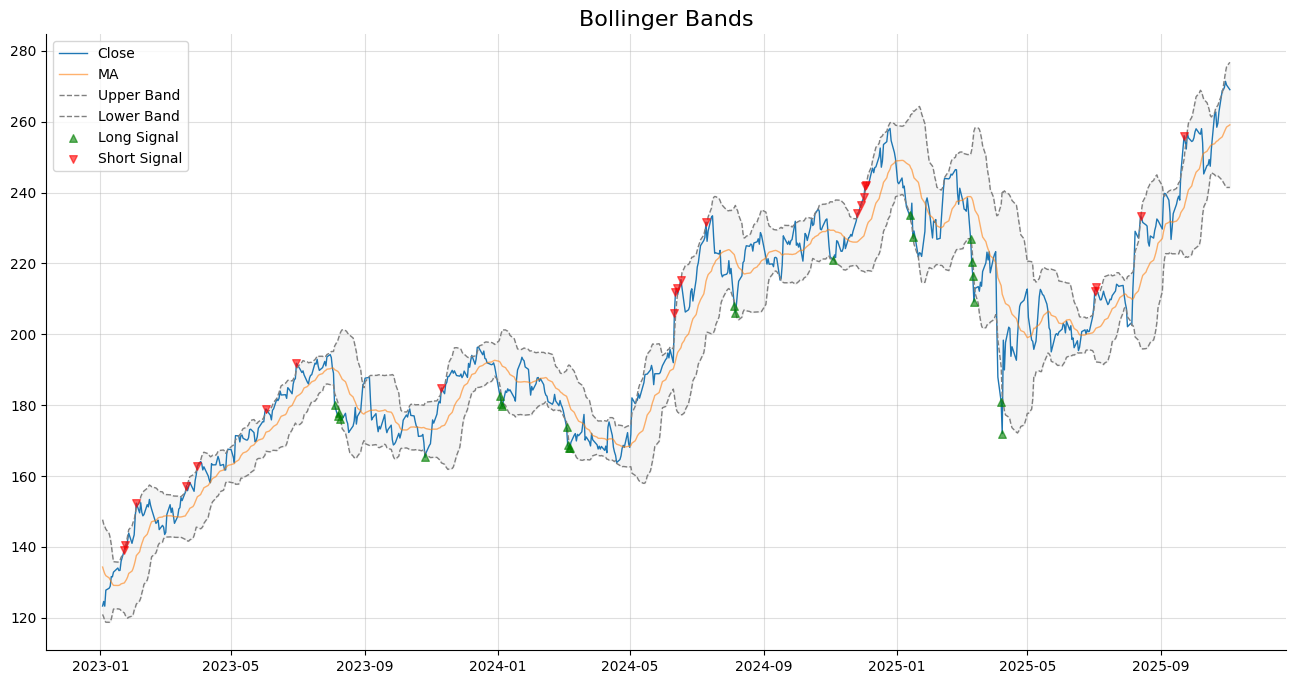

In [153]:
plot_bands(df.loc['2023':])

### RSI Plot

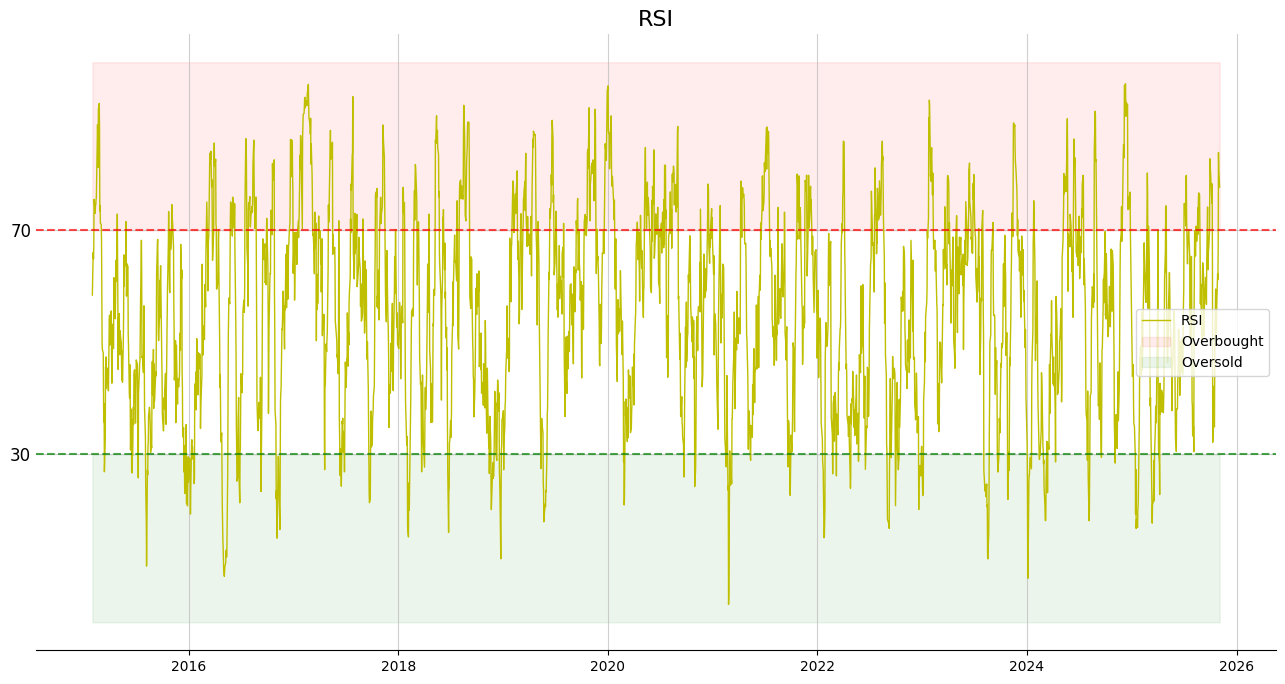

In [154]:
def plot_rsi(df):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title('RSI', fontsize=16)
    ax.plot(df['RSI'], label = 'RSI', linewidth=1, color='y')
    ax.axhline(70, color="r", linestyle="--", alpha=0.7)
    ax.axhline(30, color="g", linestyle="--", alpha=0.7)
    ax.fill_between(df.index, 70, 100, color='r', alpha=0.075, label='Overbought')
    ax.fill_between(df.index, 0, 30, color='g', alpha=0.075, label='Oversold')

    ax.grid(True, alpha=0.6)

    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.legend()
    
    ax.set_yticks([30,70])
    ax.tick_params(axis='y', labelsize=12, length=0)
    plt.show();

    return

plot_rsi(df)


### Strategy vs Buy&Hold

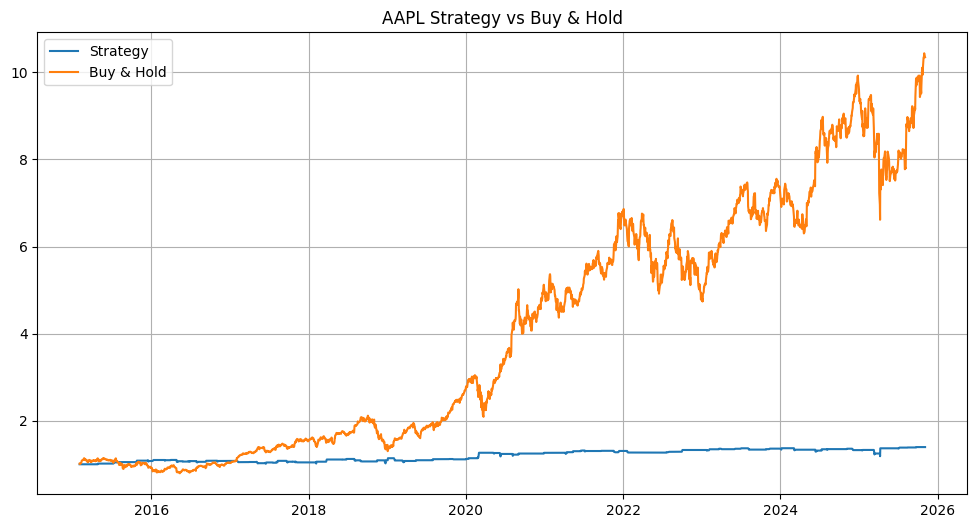

In [170]:
plt.figure(figsize=(12,6))
plt.plot(df["Strategy_Curve"], label="Strategy")
plt.plot(df["BuyHold_Curve"], label="Buy & Hold")
plt.title(f"{ticker} Strategy vs Buy & Hold")
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='Date'>

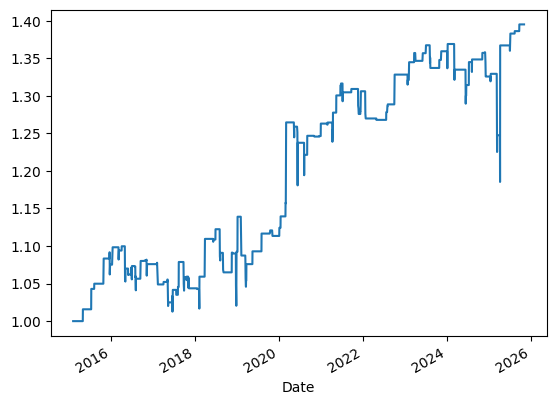

In [171]:
df['Strategy_Curve'].plot()